# Conceptular Synthesis Experiment 1: Resynthesis of a snare drum sample - Effects of N and Pattern Size with Spectral Coherence

In [1]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy 
import uuid
from scipy import signal

figsize(20,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights



In [3]:
y, sr = librosa.load("audios/snare.wav", sr=22050)
y = y[20:]


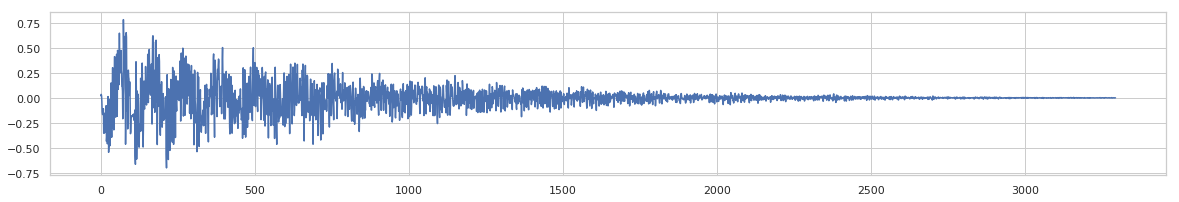

In [4]:
import seaborn as sns
sns.set(style="whitegrid")
figsize(20,3)
plot(y)


In [5]:
Audio(data=y[:],rate=sr)

In [6]:
def computeConceptor(net, i_pattern, alpha):
#     print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros(4, dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(net['p']['N'])))

    C =  U.dot(Snew).dot(U.T);
    Cs[0] = C
    Cs[1] = U
    Cs[2] = diag(Snew)
    Cs[3] = diag(S)

    return Cs


def testConceptor(net, cs, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cs[0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        z_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        x = 0.5 * np.random.randn(net['p']['N'],1) * 0.0
        z = x
        for n in range(recallTestLength + net['p']['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > net['p']['washoutLength']):
                x_CTestPL[:,n-net['p']['washoutLength']] = x.T
                z_CTestPL[:,n-net['p']['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)


def plotConceptorPattern(net, cs, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    z_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, net['p']['patts'].shape[0]))
    C = cs[0]
    x = 0.5 * np.random.randn(net['p']['N'],1) * 0
    z = x
    for n in range(recallTestLength + net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > net['p']['washoutLength']):
            x_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([net['p']['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:net['p']['patts'][i_pattern].size*2],net['p']['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
#     print(score)
#     plot(outputPattern)
#     plot(targetPattern)
    return score

def render(net, pcs, winSize, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0):
    speed = 1.0/speed
    audio = np.zeros(0)
    x = 0.5 * np.random.randn(net['p']['N'],1)
    C = pcs[0][0]
    LR = net['p']['LR'] * lrMod
    orgW = net['W']
    Wmod = orgW * alphaMod
    #run to washout
    for n in range(net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        
    for n in range(int(winSize * pcs.shape[0] * abs(speed))):
        currConceptor = int(n/abs(speed) / winSize)
#         nextConceptor = min(pcs.shape[0]-1, currConceptor+1)
        if (speed <= 0):
            currConceptor = pcs.shape[0] - currConceptor - 1  #reverse
        C = pcs[currConceptor][0] * cMod
#         C = (cNet['Cs'][0,0] * (1 - mix)) + (cNet2['Cs'][0,0] * mix)
        xOld = x
        Wtarget = (Wmod.dot(x))
        z = ((1.0 - LR) * xOld) + (LR * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        newSample = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
        audio = np.concatenate((audio, newSample))
    return audio



In [ ]:
%%time
#create a random reservoir and load it with patterns using Jaeger's method
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
#     xCollector = np.zeros((p['N'], p['learnLength']))
#     pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
#     allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainxArgs = np.zeros((p['N'] + 1, p['learnLength'] * p['patts'].shape[0]));
#     allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainOldxArgs = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
#     allTrainWtargets = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
#     allTrainOuts = np.zeros((1, 0));
    allTrainOuts = np.zeros((1, p['learnLength'] * p['patts'].shape[0]));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
#     print('Loading patterns: ', end='')
    for i_pattern in range(p['patts'].shape[0]):
#         print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        storeBegin = i_pattern * p['learnLength']
        storeEnd = (i_pattern * p['learnLength']) + p['learnLength']
        patternRs[0,i_pattern] = R
#         allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainxArgs[:,storeBegin : storeEnd ] = xCollector
#         allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOldxArgs[:,storeBegin : storeEnd ] = xOldCollector
#         allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainOuts[:,storeBegin : storeEnd ] = pCollector
#         allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)
        allTrainWtargets[:,storeBegin : storeEnd ]  = WTargetCollector


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
#     print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
#     print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
#     print("NRMSE W: ", NRMSE_W, " :: ", end='')
#     print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout','NRMSE_readout', 'absSize_readout')}
    return data

    


    


def testModel(params, windowSize):
    
    simpleParams = {k: v for k, v in params.items() if k not in ('patts')}
    testResults = {"p":simpleParams,"windowSize":windowSize}
    sampleSize = 10
    print(simpleParams)
    loadedNets = np.zeros(sampleSize, dtype=np.object)
    for i_net, net in enumerate(loadedNets):
        print(i_net, ".", end='')
        loadedNets[i_net] = makeLoadedNetwork_v2(params)
    nrmses = [x['NRMSE_readout'] for x in loadedNets]
    bestNetwork = np.argmin(nrmses)
    print("\nNRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_readout'], "avg: ", np.mean(nrmses) )
    testResults["loading error"] = loadedNets[bestNetwork]['NRMSE_readout']
    def fitnessf(aperture, *args):
        print(args[0], ".", end='')
        cs = computeConceptor(loadedNets[bestNetwork], args[0], aperture)
        atten = testConceptor(loadedNets[bestNetwork], cs, windowSize*4)
        return atten

    apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=0, xtol=1, args = (x,)) 
                 for x in np.arange(params['patts'].shape[0])]

    patternCs = np.zeros(len(apertures), dtype=np.object)
    scores = np.zeros(len(apertures))
    for i_patt in range(len(apertures)):
        print(i_patt,".",end='')
        patternCs[i_patt] = computeConceptor(loadedNets[bestNetwork], i_patt, apertures[i_patt])
        scores[i_patt] = plotConceptorPattern(loadedNets[bestNetwork], patternCs[i_patt], windowSize * 5, i_patt)

    print('\nScore: ',np.mean(scores))
    testResults["recon scores"] = scores
#     testResults["net"] = loadedNets[bestNetwork]
#     testResults["Cs"] = patternCs
    audio = render(loadedNets[bestNetwork], patternCs, windowSize, 1.0, 1.0, 1, 1.0)
    testResults["reconScore"] = nrmse(audio, y[:audio.size])
    librosa.output.write_wav("results/patternSize_N/snare_patternsize_" + str(windowSize) + "N_" + str(params["N"]) + "--" + str(uuid.uuid4()) + ".wav", audio, sr)
    testResults["audio"] = audio
    def coh(sig1,sig2):
        return 1 - np.mean(signal.coherence(sig1,sig2, sr, nperseg=128)[1])
    testResults["coh"] = coh(y[:audio.size],audio)
    print("Recon scores: ", testResults["reconScore"], testResults["coh"])
    return testResults




allResults = []
Ws = [2,4,6,8,10,12,15] 
Ns = [50,100,200,400,800]
# Ws = [5,10] 
for v_n in Ns:
    for v_w in Ws:
        for i in range(5):
            windowSize=v_w
            padding = windowSize - (y.size % windowSize)
            y = np.concatenate((y, np.zeros(padding)))
            nWindows = int(y.size/windowSize)
            print(y.shape, nWindows)
            #divide out windows
            patterns = np.zeros((nWindows, windowSize))
            for i in range(nWindows):
                patterns[i] = y[i*windowSize : (i+1) * windowSize]

            p = {'N':v_n, 'NetSR':1.5, 'NetinpScaling':1.2,'BiasScaling':0.5,'TychonovAlpha':0.0001,
                     'washoutLength':windowSize*4, 'learnLength':windowSize * 4, 'TychonovAlphaReadout':0.001,
                      'LR': 0.99,
                       'patts':patterns[np.arange(int(1500/windowSize))]
                     }
            res = testModel(p, windowSize)
            allResults = append(allResults, res)


(4722,) 2361
{'washoutLength': 8, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 50, 'LR': 0.99, 'learnLength': 8, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0406693361251 avg:  0.0725359649888


0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .1

 .496 .496 .496 .496 .496 .496 .496 .496 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509

 .614 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .628 .628 .628 .628 .628 .628

 .734 .734 .734 .734 .734 .734 .734 .734 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20

 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .503 .503 .503 .503 .503 .503 .503

 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .609 .609 .609 .609 .609 .609 .609 .609 .609 .609 .609 .609 .609 .609 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .610 .611 .611 .611 .611 .611 .611 .611 .611 .611 .611 .611 .611 .611 .611 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .618 .618 .618 .618 .618 .618 .618 .618

 .720 .720 .720 .720 .720 .720 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .724 .724 .724 .724 .724 .724 .724 .724 .724 .724 .724 .724 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .725 .726 .726 .726 .726 .726 .726 .726 .726 .726 .726 .726 .726 .726 .726 .726 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .727 .728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .734 .734 .734 .734

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 

 .493 .493 .493 .493 .493 .493 .493 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .494 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .495 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .496 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .497 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .498 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .499 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .500 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .501 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .502 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .503 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .504 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506

 .611 .611 .611 .611 .611 .611 .611 .611 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .612 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .613 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .614 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .615 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .616 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .617 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .618 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .619 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .620 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .621 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624

728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .728 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .729 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .730 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .731 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .732 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .733 .734 .734 .734 .734 .734 .734 .734 .734 .734 .734 .734 .734 .734 .734 .734 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .735 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .736 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .737 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .738 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .741 .741 .741 .741 .741 .741 .741 .741 .741 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .2

 .548 .548 .548 .548 .548 .548 .548 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .563 .563 .563 .563 .563

 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .689 .689 .689 .689 .689 .689 .689 .689 .689 .689 .689 .689

718 .719 .720 .721 .722 .723 .724 .725 .726 .727 .728 .729 .730 .731 .732 .733 .734 .735 .736 .737 .738 .739 .740 .741 .742 .743 .744 .745 .746 .747 .748 .749 .
Score:  0.933360433236
Recon scores:  0.907669888585 0.612986262695
(4730,) 2365
{'washoutLength': 8, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 50, 'LR': 0.99, 'learnLength': 8, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0316555022103 avg:  0.0748096537103


0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .1

 .504 .504 .504 .504 .504 .504 .504 .504 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .505 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .506 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .507 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .508 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .509 .510 .510 .510 .510 .510 .510 .510 .510 .510 .510 .510 .510 .510 .510 .510 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .511 .512 .512 .512 .512 .512 .512 .512 .512 .512 .512 .512 .512 .512 .512 .512 .513 .513 .513 .513 .513 .513 .513 .513 .513 .513 .513 .513 .513 .513 .513 .514 .514 .514 .514 .514 .514 .514 .514 .514 .514 .514 .514 .515 .515 .515 .515 .515 .515 .515 .515 .515 .515 .515 .515 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .516 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .517 .518 .518

 .621 .621 .621 .621 .621 .621 .621 .621 .621 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .622 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .623 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .624 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .625 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .626 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .627 .628 .628 .628 .628 .628 .628 .628 .628 .628 .628 .628 .628 .628 .629 .629 .629 .629 .629 .629 .629 .629 .629 .629 .629 .629 .629 .629 .629 .630 .630 .630 .630 .630 .630 .630 .630 .630 .630 .630 .630 .630 .630 .630 .631 .631 .631 .631 .631 .631 .631 .631 .631 .631 .631 .631 .631 .631 .632 .632 .632 .632 .632 .632 .632 .632 .632 .632 .632 .632 .632 .632 .632 .633 .633 .633 .633 .633 .633 .633 .633 .633 .633 .633 .633 .633 .634 .634 .634 .634 .634 .634 .634 .634 .634 .634 .634 .634 .634

 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .

.305 .305 .305 .305 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .306 .307 .307 .307 .307 .307 .307 .307 .307 .307 .307 .307 .308 .308 .308 .308 .308 .308 .308 .308 .308 .308 .308 .308 .308 .308 .309 .309 .309 .309 .309 .309 .309 .310 .310 .310 .310 .310 .310 .310 .310 .310 .310 .310 .311 .311 .311 .311 .311 .311 .311 .311 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .312 .313 .313 .313 .313 .313 .313 .313 .313 .314 .314 .314 .314 .314 .314 .314 .314 .314 .314 .315 .315 .315 .315 .315 .315 .315 .315 .315 .315 .315 .316 .316 .316 .316 .316 .316 .316 .316 .316 .316 .316 .316 .316 .316 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .317 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .318 .319 .319 .319 .319 .319 .319 .319 .319 .319 .319 .319 .319 .319 .320 .320 .320 .320 .320 .320 .320 .320 .320 .320 .320 .321 .321 .321 .321 .321 .321 .321 .321 .322 .322 .322 .322 .322 .322 

0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .

 .325 .325 .325 .325 .325 .325 .325 .325 .325 .325 .325 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .326 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .327 .328 .328 .328 .328 .328 .328 .328 .328 .329 .329 .329 .329 .329 .329 .329 .329 .329 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .338 .338 .338 .338 .338 .338 .338 .338 .338 .339 .339 .339 .339 .339 .339 .339 .339 .339 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .341

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .

155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164 .164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .166 .166 .166 .166 .166 .166 .166 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .171 .171 .171 .171 .171 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .23 .23

.167 .167 .167 .167 .167 .167 .167 .167 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .171 .171 .171 .171 .171 .171 .171 .171 .171 .172 .172 .172 .172 .172 .172 .172 .172 .172 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .176 .176 .176 .176 .176 .176 .176 .176 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .178 .178 .178 .178 .178 .178 .178 .178 .179 .179 .179 .179 .179 .179 .179 .179 .179 .179 .179 .180 .180 .180 .180 .180 .180 .180 .180 .180 .181 .181 .181 .181 .181 .181 .181 .181 .181 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .182 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .183 .184 .184 .184 .184 .184 .184 .184 .184 .184 .184 .184 .184 .184 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23

 .166 .166 .166 .166 .166 .166 .166 .166 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .178 .178 .178 .178 .178 .178 .178 .178 .178 .178 .179 .179 .179 .179 .179 .179 .179 .180 .180 .180 .180 .180 .180 .180 .180 .180 .180 .180 .180 .181 .181 .181 .181 .181 .181 .181 .181 .181 .181 .181 .181 .181 .182 .182 .182 .182 .182 .182

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 

 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .150 .150 .150 .150 .150 .150 .150 .150 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .

151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 

148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  2.01467946876
Recon scores:  1.40926218013 0.865670740733
(4840,) 484
{'washoutLength': 40, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 50, 'LR': 0.99, 'learnLength': 40, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .

52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  1.19859614597
Recon scores:  1.21296184226 0.899623282483
(4860,) 486
{'washoutLength': 40, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 50, 'LR': 0.99, 'learnLength': 40, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0131737740204 avg:  0.0597146053448
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .

 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147

242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .251 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .252 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .253 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .254 .255 .255 .255 .255 .255 .255 .255 .255 .255 .255 .

351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .360 .361 .361 .361 .361 .361 .361 .361 .361 .361 .361 .361 .361 .361 .361 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .

 .459 .459 .459 .459 .459 .459 .459 .459 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .469 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .470 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .471 .472 .472 .472 .472

567 .567 .567 .567 .567 .567 .567 .567 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .578 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .579 .580 .580 .580 .580 .580 .

676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .685 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .686 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .687 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .688 .689 .

 .549 .550 .551 .552 .553 .554 .555 .556 .557 .558 .559 .560 .561 .562 .563 .564 .565 .566 .567 .568 .569 .570 .571 .572 .573 .574 .575 .576 .577 .578 .579 .580 .581 .582 .583 .584 .585 .586 .587 .588 .589 .590 .591 .592 .593 .594 .595 .596 .597 .598 .599 .600 .601 .602 .603 .604 .605 .606 .607 .608 .609 .610 .611 .612 .613 .614 .615 .616 .617 .618 .619 .620 .621 .622 .623 .624 .625 .626 .627 .628 .629 .630 .631 .632 .633 .634 .635 .636 .637 .638 .639 .640 .641 .642 .643 .644 .645 .646 .647 .648 .649 .650 .651 .652 .653 .654 .655 .656 .657 .658 .659 .660 .661 .662 .663 .664 .665 .666 .667 .668 .669 .670 .671 .672 .673 .674 .675 .676 .677 .678 .679 .680 .681 .682 .683 .684 .685 .686 .687 .688 .689 .690 .691 .692 .693 .694 .695 .696 .697 .698 .699 .700 .701 .702 .703 .704 .705 .706 .707 .708 .709 .710 .711 .712 .713 .714 .715 .716 .717 .718 .719 .720 .721 .722 .723 .724 .725 .726 .727 .728 .729 .730 .731 .732 .733 .734 .735 .736 .737 .738 .739 .740 .741 .742 .743 .744 .745 .746 .747 .748

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 

 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .454 .454 .454 .454 .454 .454

 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558

650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .

132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .221 .222 .223 .224 .225 .226 .227 .228 .229 .230 .231 .232 .233 .234 .235 .236 .237 .238 .239 .240 .241 .242 .243 .244 .245 .246 .247 .248 .249 .250 .251 .252 .253 .254 .255 .256 .257 .258 .259 .260 .261 .262 .263 .264 .265 .266 .267 .268 .269 .270 .271 .272 .273 .274 .275 .276 .277 .278 .279 .280 .281 .282 .283 .284 .285 .286 .287 .288 .289 .290 .291 .292 .293 .294 .295 .296 .297 .298 .299 .300 .301 .302 .303 .304 .305 .306 .307 .308 .309 .310 .311 .312 .313 .314 .315 .316 .317 .318 .319 .320 .321 .322 .323 .324 .325 .326 .327 .328 .329 .330 .331 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

 .449 .449 .449 .449 .449 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .462 .462 .462 .462 .462 .462 .462 .462 .462

 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567

 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .671 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672

255 .256 .257 .258 .259 .260 .261 .262 .263 .264 .265 .266 .267 .268 .269 .270 .271 .272 .273 .274 .275 .276 .277 .278 .279 .280 .281 .282 .283 .284 .285 .286 .287 .288 .289 .290 .291 .292 .293 .294 .295 .296 .297 .298 .299 .300 .301 .302 .303 .304 .305 .306 .307 .308 .309 .310 .311 .312 .313 .314 .315 .316 .317 .318 .319 .320 .321 .322 .323 .324 .325 .326 .327 .328 .329 .330 .331 .332 .333 .334 .335 .336 .337 .338 .339 .340 .341 .342 .343 .344 .345 .346 .347 .348 .349 .350 .351 .352 .353 .354 .355 .356 .357 .358 .359 .360 .361 .362 .363 .364 .365 .366 .367 .368 .369 .370 .371 .372 .373 .374 .375 .376 .377 .378 .379 .380 .381 .382 .383 .384 .385 .386 .387 .388 .389 .390 .391 .392 .393 .394 .395 .396 .397 .398 .399 .400 .401 .402 .403 .404 .405 .406 .407 .408 .409 .410 .411 .412 .413 .414 .415 .416 .417 .418 .419 .420 .421 .422 .423 .424 .425 .426 .427 .428 .429 .430 .431 .432 .433 .434 .435 .436 .437 .438 .439 .440 .441 .442 .443 .444 .445 .446 .447 .448 .449 .450 .451 .452 .453 .454 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .

447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .450 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .451 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .452 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .453 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .454 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .455 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .

 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .554 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .555 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .556 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .557 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .558 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .559 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .560 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .561 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .562 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .563 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .564 .565 .565

658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .658 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .659 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .660 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .661 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .662 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .663 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .664 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .665 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .666 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .667 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .668 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .669 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .670 .

245 .246 .247 .248 .249 .250 .251 .252 .253 .254 .255 .256 .257 .258 .259 .260 .261 .262 .263 .264 .265 .266 .267 .268 .269 .270 .271 .272 .273 .274 .275 .276 .277 .278 .279 .280 .281 .282 .283 .284 .285 .286 .287 .288 .289 .290 .291 .292 .293 .294 .295 .296 .297 .298 .299 .300 .301 .302 .303 .304 .305 .306 .307 .308 .309 .310 .311 .312 .313 .314 .315 .316 .317 .318 .319 .320 .321 .322 .323 .324 .325 .326 .327 .328 .329 .330 .331 .332 .333 .334 .335 .336 .337 .338 .339 .340 .341 .342 .343 .344 .345 .346 .347 .348 .349 .350 .351 .352 .353 .354 .355 .356 .357 .358 .359 .360 .361 .362 .363 .364 .365 .366 .367 .368 .369 .370 .371 .372 .373 .374 .375 .376 .377 .378 .379 .380 .381 .382 .383 .384 .385 .386 .387 .388 .389 .390 .391 .392 .393 .394 .395 .396 .397 .398 .399 .400 .401 .402 .403 .404 .405 .406 .407 .408 .409 .410 .411 .412 .413 .414 .415 .416 .417 .418 .419 .420 .421 .422 .423 .424 .425 .426 .427 .428 .429 .430 .431 .432 .433 .434 .435 .436 .437 .438 .439 .440 .441 .442 .443 .444 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .

479 .480 .480 .480 .480 .480 .480 .480 .480 .480 .480 .480 .480 .480 .480 .480 .481 .481 .481 .481 .481 .481 .481 .481 .481 .481 .481 .481 .481 .482 .482 .482 .482 .482 .482 .482 .482 .482 .482 .482 .482 .482 .482 .482 .483 .483 .483 .483 .483 .483 .483 .483 .483 .483 .483 .483 .483 .483 .484 .484 .484 .484 .484 .484 .484 .484 .484 .484 .484 .484 .484 .484 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .485 .486 .486 .486 .486 .486 .486 .486 .486 .486 .486 .486 .486 .486 .486 .486 .487 .487 .487 .487 .487 .487 .487 .487 .487 .487 .487 .487 .487 .487 .487 .488 .488 .488 .488 .488 .488 .488 .488 .488 .488 .488 .488 .488 .488 .488 .489 .489 .489 .489 .489 .489 .489 .489 .489 .489 .489 .489 .489 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .490 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .491 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .492 .493 .493 .493 .493 .493 .493 .493 .493 .493 .493 .

 .595 .595 .595 .595 .595 .595 .595 .595 .595 .595 .595 .596 .596 .596 .596 .596 .596 .596 .596 .596 .596 .596 .596 .596 .596 .597 .597 .597 .597 .597 .597 .597 .597 .597 .597 .597 .597 .597 .597 .597 .598 .598 .598 .598 .598 .598 .598 .598 .598 .598 .598 .598 .598 .598 .599 .599 .599 .599 .599 .599 .599 .599 .599 .599 .599 .599 .599 .599 .599 .600 .600 .600 .600 .600 .600 .600 .600 .600 .600 .600 .600 .600 .600 .601 .601 .601 .601 .601 .601 .601 .601 .601 .601 .601 .601 .601 .601 .601 .602 .602 .602 .602 .602 .602 .602 .602 .602 .602 .602 .602 .602 .602 .603 .603 .603 .603 .603 .603 .603 .603 .603 .603 .603 .603 .603 .603 .603 .604 .604 .604 .604 .604 .604 .604 .604 .604 .604 .604 .604 .604 .604 .604 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .605 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .606 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .607 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .608 .609 .609

 .711 .711 .711 .711 .711 .711 .711 .711 .711 .711 .711 .712 .712 .712 .712 .712 .712 .712 .712 .712 .712 .712 .712 .712 .712 .713 .713 .713 .713 .713 .713 .713 .713 .713 .713 .713 .713 .713 .713 .714 .714 .714 .714 .714 .714 .714 .714 .714 .714 .714 .714 .714 .714 .714 .715 .715 .715 .715 .715 .715 .715 .715 .715 .715 .715 .715 .715 .716 .716 .716 .716 .716 .716 .716 .716 .716 .716 .716 .716 .716 .716 .717 .717 .717 .717 .717 .717 .717 .717 .717 .717 .717 .717 .717 .717 .717 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .718 .719 .719 .719 .719 .719 .719 .719 .719 .719 .719 .719 .719 .719 .719 .720 .720 .720 .720 .720 .720 .720 .720 .720 .720 .720 .720 .720 .720 .720 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .721 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .722 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .723 .724 .724 .724 .724 .724 .724 .724 .724 .724 .724 .724 .725 .725 .725 .725

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .

262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .262 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .263 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .264 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .265 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .266 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .267 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .268 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .269 .270 .270 .270 .270 .270 .270 .270 .270 .270 .270 .270 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .271 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .272 .273 .273 .273 .273 .273 .273 .273 .273 .273 .273 .273 .273 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .274 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .275 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .276 .277 .277 .277 .277 .277 .277 .277 .277 .

183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .221 .222 .223 .224 .225 .226 .227 .228 .229 .230 .231 .232 .233 .234 .235 .236 .237 .238 .239 .240 .241 .242 .243 .244 .245 .246 .247 .248 .249 .250 .251 .252 .253 .254 .255 .256 .257 .258 .259 .260 .261 .262 .263 .264 .265 .266 .267 .268 .269 .270 .271 .272 .273 .274 .275 .276 .277 .278 .279 .280 .281 .282 .283 .284 .285 .286 .287 .288 .289 .290 .291 .292 .293 .294 .295 .296 .297 .298 .299 .300 .301 .302 .303 .304 .305 .306 .307 .308 .309 .310 .311 .312 .313 .314 .315 .316 .317 .318 .319 .320 .321 .322 .323 .324 .325 .326 .327 .328 .329 .330 .331 .332 .333 .334 .335 .336 .337 .338 .339 .340 .341 .342 .343 .344 .345 .346 .347 .348 .349 .350 .351 .352 .353 .354 .355 .356 .357 .358 .359 .360 .361 .362 .363 .364 .365 .366 .367 .368 .369 .370 .371 .372 .373 .374 .
Score:  0.61147094376
Recon scores:  0.

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .1

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .23 .23 .23 .23 .23 .23 .23 .23 .24 .24 .24 .24 .24 .24 .24 .24 .24 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 

 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .170 .170 .170 .170 .170 .170 .170 .170 .170 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .175 .175 .175 .175 .175 .175 .175 .175 .175 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .177 .177 .177 .177

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .

156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164 .164 .164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .168 .168 .168 .168 .168 .168 .168 .168 .168 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .172 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .174 .174 .174 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .2

149 .149 .149 .149 .150 .150 .150 .150 .150 .150 .150 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .

 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161

0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22

164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .166 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .167 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .168 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .169 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .170 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .171 .172 .172 .172 .172 .172 .172 .172 .172 .172 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .173 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .174 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .175 .176 .176 .176 .176 .176 .176 .176 .176 .176 .176 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .177 .178 .178 .178 .178 .178 .178 .178 .178 .178 .178 .178 .178 .178 .179 .179 .179 .179 .179 .179 .179 .179 .179 .179 .179 .179 .179 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .2

142 .143 .143 .143 .143 .143 .143 .143 .143 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0140746238397 avg:  0.057902994722
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .23 .2

 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  1.0558852542
Recon scores:  1.12816462371 0.87469579112
(5136,) 428
{'washoutLength': 48, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 100, 'LR': 0.99, 'learnLength': 48, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0100062002479 avg:  0.0542755030853
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .

129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .142 .142 .142 .142 .142 .142 .142 .

237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .250 .

346 .346 .346 .346 .346 .346 .346 .346 .346 .346 .346 .346 .346 .346 .346 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .359 .359 .359 .

455 .455 .455 .455 .455 .455 .455 .455 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .456 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .457 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .458 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .459 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .460 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .461 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .462 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .463 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .464 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .465 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .466 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .467 .468 .468 .468 .468 .468 .468 .468 .468 .468 .468 .

564 .564 .564 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .565 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .566 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .567 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .568 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .569 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .570 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .571 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .572 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .573 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .574 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .575 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .576 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .577 .

 .671 .671 .671 .671 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .672 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .673 .674 .674 .674 .674 .674 .674 .674 .674 .674 .674 .674 .674 .674 .674 .674 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .675 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .676 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .677 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .678 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .679 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .680 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .681 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .682 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .683 .684 .684 .684 .684 .684 .684 .684 .684 .684 .684

 .470 .471 .472 .473 .474 .475 .476 .477 .478 .479 .480 .481 .482 .483 .484 .485 .486 .487 .488 .489 .490 .491 .492 .493 .494 .495 .496 .497 .498 .499 .500 .501 .502 .503 .504 .505 .506 .507 .508 .509 .510 .511 .512 .513 .514 .515 .516 .517 .518 .519 .520 .521 .522 .523 .524 .525 .526 .527 .528 .529 .530 .531 .532 .533 .534 .535 .536 .537 .538 .539 .540 .541 .542 .543 .544 .545 .546 .547 .548 .549 .550 .551 .552 .553 .554 .555 .556 .557 .558 .559 .560 .561 .562 .563 .564 .565 .566 .567 .568 .569 .570 .571 .572 .573 .574 .575 .576 .577 .578 .579 .580 .581 .582 .583 .584 .585 .586 .587 .588 .589 .590 .591 .592 .593 .594 .595 .596 .597 .598 .599 .600 .601 .602 .603 .604 .605 .606 .607 .608 .609 .610 .611 .612 .613 .614 .615 .616 .617 .618 .619 .620 .621 .622 .623 .624 .625 .626 .627 .628 .629 .630 .631 .632 .633 .634 .635 .636 .637 .638 .639 .640 .641 .642 .643 .644 .645 .646 .647 .648 .649 .650 .651 .652 .653 .654 .655 .656 .657 .658 .659 .660 .661 .662 .663 .664 .665 .666 .667 .668 .669

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .449 .449 .449 .

540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .

643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .

746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18

437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .448 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .449 .450 .450 .450 .450 .450 .

541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .551 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .552 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .553 .554 .554 .

645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .654 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .655 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .656 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .657 .658 .658 .658 .

749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .447 .447 .447 .447 .447 .447 .447 .447 .

538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .551 .

642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .654 .654 .654 .654 .654 .654 .654 .654 .654 .

 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .446 .447 .447 .447 .447 .447 .447 .447 .447 .447 .447 .

538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .548 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .549 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .550 .

641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .651 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .652 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .653 .654 .654 .654 .654 .654 .654 .

745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .

260 .261 .262 .263 .264 .265 .266 .267 .268 .269 .270 .271 .272 .273 .274 .275 .276 .277 .278 .279 .280 .281 .282 .283 .284 .285 .286 .287 .288 .289 .290 .291 .292 .293 .294 .295 .296 .297 .298 .299 .300 .301 .302 .303 .304 .305 .306 .307 .308 .309 .310 .311 .312 .313 .314 .315 .316 .317 .318 .319 .320 .321 .322 .323 .324 .325 .326 .327 .328 .329 .330 .331 .332 .333 .334 .335 .336 .337 .338 .339 .340 .341 .342 .343 .344 .345 .346 .347 .348 .349 .350 .351 .352 .353 .354 .355 .356 .357 .358 .359 .360 .361 .362 .363 .364 .365 .366 .367 .368 .369 .370 .371 .372 .373 .374 .
Score:  0.913459046822
Recon scores:  0.911913819442 0.72183399419
(5272,) 1318
{'washoutLength': 16, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 200, 'LR': 0.99, 'learnLength': 16, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0136336515665 avg:  0.0394280089108


0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .1

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .

263 .264 .265 .266 .267 .268 .269 .270 .271 .272 .273 .274 .275 .276 .277 .278 .279 .280 .281 .282 .283 .284 .285 .286 .287 .288 .289 .290 .291 .292 .293 .294 .295 .296 .297 .298 .299 .300 .301 .302 .303 .304 .305 .306 .307 .308 .309 .310 .311 .312 .313 .314 .315 .316 .317 .318 .319 .320 .321 .322 .323 .324 .325 .326 .327 .328 .329 .330 .331 .332 .333 .334 .335 .336 .337 .338 .339 .340 .341 .342 .343 .344 .345 .346 .347 .348 .349 .350 .351 .352 .353 .354 .355 .356 .357 .358 .359 .360 .361 .362 .363 .364 .365 .366 .367 .368 .369 .370 .371 .372 .373 .374 .
Score:  0.817352808464
Recon scores:  0.917991605544 0.714182926292
(5280,) 1320
{'washoutLength': 16, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 200, 'LR': 0.99, 'learnLength': 16, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0108352885605 avg:  0.0373148990342


0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .

57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .221 .222 .223 .224 .225 .226 .227 .228 .229 .230 .231 .232 .233 .234 .235 .236 .237 .238 .239 .240 .241 .242 .243 .244 .245 .246 .247 .248 .249 .
Score:  0.928023767415
Recon scores:  0.991873749766 0.77479106431
(5298,) 88

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0175597514004 avg:  0.0615906446472
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .2

81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .221 .222 .223 .224 .225 .226 .227 .228 .229 .230 .231 .232 .233 .234 .235 .236 .237 .238 .239 .240 .241 .242 .243 .244 .245 .246 .247 .248 .249 .
Score:  1.03484878344
Recon scores:  0.962138612018 0.760566351922
(5312,) 664
{'washoutLength': 32, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 

140 .140 .140 .140 .140 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .

151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .162 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .163 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .164 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .165 .166 .166 .166 .166 .166 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 

87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  0.758600807561
Recon scores:  1.14092785148 0.858103543039
(5360,) 536
{'washoutLength': 40, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 200, 'LR': 0.99, 'learnLength': 40, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0192694582664 avg:  0.0408634084033
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .2

130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  0.858063603996
Recon scores:  1.12732124811 0.851436319099
(5380,) 538
{'washoutLength': 40, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 200, 'LR': 0.99, 'learnLength': 40, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0149321517743 avg:  0.0362383828655
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .23 .23 .23 .23 .24 .24 .24 .24 .24 .24 .24 .24 .24 .24 .25 .25 .25 .25 .2

114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  0.660396087104
Recon scores:  1.17433183838 0.869954091251
(5400,) 450
{'washoutLength': 48, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N': 200, 'LR': 0.99, 'learnLength': 48, 'NetinpScaling': 1.2, 'NetSR': 1.5}
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.0189090365827 avg:  0.0380430282186
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 

0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .
NRMSEs: best:  0.023611521146 avg:  0.0514635474477
0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .23

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

124 .124 .124 .124 .124 .124 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .125 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .126 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .127 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .128 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .129 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .130 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .131 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .132 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .133 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .134 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .137 .137 .

227 .227 .227 .227 .227 .227 .227 .227 .227 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .228 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .229 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .230 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .231 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .232 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .233 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .234 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .235 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .

330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .330 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .331 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .332 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .333 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .334 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .335 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .336 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .337 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .338 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .339 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .340 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .341 .342 .342 .342 .342 .342 .342 .342 .342 .342 .342 .342 .342 .

433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .

535 .535 .535 .535 .535 .535 .535 .535 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .

638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .

741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

432 .432 .432 .432 .432 .432 .432 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .

535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .

638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .

740 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .7

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .445 .445 .445 .

535 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .548 .548 .548 .548 .

638 .638 .638 .638 .638 .638 .638 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .651 .

741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

432 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .445 .

535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .

638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .

741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

432 .432 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .444 .445 .445 .445 .445 .445 .445 .

535 .535 .535 .535 .535 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .547 .548 .548 .548 .

638 .638 .638 .638 .638 .638 .638 .638 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .649 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .650 .

741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 

362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .362 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .363 .364 .364 .364 .364 .364 .364 .364 .364 .364 .364 .364 .364 .364 .364 .364 .365 .365 .365 .365 .365 .365 .365 .365 .365 .365 .365 .365 .365 .365 .366 .366 .366 .366 .366 .366 .366 .366 .366 .366 .366 .366 .366 .366 .366 .367 .367 .367 .367 .367 .367 .367 .367 .367 .367 .367 .367 .367 .367 .368 .368 .368 .368 .368 .368 .368 .368 .368 .368 .368 .368 .368 .368 .369 .369 .369 .369 .369 .369 .369 .369 .369 .369 .369 .369 .369 .369 .369 .370 .370 .370 .370 .370 .370 .370 .370 .370 .370 .370 .370 .370 .370 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .371 .372 .372 .372 .372 .372 .372 .372 .372 .372 .372 .372 .372 .372 .372 .373 .373 .373 .373 .373 .373 .373 .373 .373 .373 .373 .373 .373 .373 .374 .374 .374 .374 .374 .374 .374 .374 .374 .374 .374 .374 .374 .374 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .

347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .347 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .348 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .349 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .350 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .351 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .352 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .353 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .354 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .355 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .356 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .357 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .358 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .359 .360 .360 .360 .360 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 

240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .7

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 

236 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .237 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .238 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .239 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .240 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .241 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .242 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .243 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .244 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .245 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .246 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .247 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .248 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .249 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21

145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .160 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .161 .162 .162 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 

145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .150 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .151 .152 .152 .152 .152 .152 .152 .152 .152 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .153 .154 .154 .154 .154 .154 .154 .154 .154 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .155 .156 .156 .156 .156 .156 .156 .156 .156 .156 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .157 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .158 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .159 .160 .160 .160 .160 .160 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .2

134 .134 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .135 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .136 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .137 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .138 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .139 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .140 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .141 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .142 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .143 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .144 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20

144 .144 .144 .144 .144 .144 .144 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .145 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .146 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  0.7737

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20

147 .147 .147 .147 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .148 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .149 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .
Score:  0.878774216048
Recon scores:  1.10858719873 0.857441061351
(5652,) 471
{'washoutLength': 48, 'TychonovAlphaReadout': 0.001, 'TychonovAlpha': 0.0001, 'BiasScaling': 0.5, 'N

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .21 .22 .22 .22 .22 .22 .22 .22 .22 .22 .22 .23 .23 .23 .23 .23 .23 .23 .24 .2

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .18 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .19 .20 .20 .20 .20 .20 .20 .20 .20 .20 .21 .21 .21 .21 .21 .21 .21 .21 

0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .0 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .1 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .2 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .3 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .4 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .5 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .6 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .7 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .8 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .9 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .10 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .11 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .12 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .13 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .14 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .15 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .16 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .17 .18 .18 .

431 .431 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .432 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .433 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .434 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .435 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .436 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .437 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .438 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .439 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .440 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .441 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .442 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .443 .444 .444 .444 .444 .444 .444 .

534 .534 .534 .534 .534 .534 .534 .534 .534 .534 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .535 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .536 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .537 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .538 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .539 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .540 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .541 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .542 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .543 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .544 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .545 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .546 .

636 .636 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .637 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .638 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .639 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .640 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .641 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .642 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .643 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .644 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .645 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .646 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .647 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .648 .649 .649 .649 .649 .649 .649 .

739 .739 .739 .739 .739 .739 .739 .739 .739 .739 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .740 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .741 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .742 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .743 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .744 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .745 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .746 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .747 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .748 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .749 .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .

In [6]:
# import dill as pickle
# with open(r"results/expt1VaryingPatternSize_N.pickled", "wb") as output_file:    
#     pickle.dump(allResults, output_file, protocol=0)
# import dill as pickle
# with open(r"results/expt1VaryingPatternSize_N.pickled", "rb") as in_file:    
#     allResults = pickle.load(in_file)

In [42]:
a = np.array([[x['p']['learnLength']/4, x['p']['N'], np.mean(x['recon scores'])] for x in allResults if x['p']['N'] !=0])
Ws = [4,6,8,10,12,15,20] 
Ns = [50,100,200,400]
avgs = np.zeros((len(Ws) * len(Ns),3))
idx=0
for v_n in Ns:
    for v_w in Ws:
        g = [v_n, v_w, np.min([x[2] for x in a if x[0]==v_w and x[1] == v_n])]
        print(g)
        avgs[idx] = g
        idx=idx+1

[50, 4, 0.61744778216765372]
[50, 6, 0.76361985887201966]
[50, 8, 0.95021308302183694]
[50, 10, 1.1449639310022592]
[50, 12, 1.2954665788186777]
[50, 15, 1.4240170498540508]
[50, 20, 1.4026737504833338]
[100, 4, 0.69493449632118987]
[100, 6, 0.59851534088789826]
[100, 8, 0.78314536371659627]
[100, 10, 0.98714889736501243]
[100, 12, 1.1620334374888903]
[100, 15, 1.0463561546935169]
[100, 20, 1.4092251680163101]
[200, 4, 0.79047020688907654]
[200, 6, 0.48549904855776926]
[200, 8, 0.62166685547940659]
[200, 10, 0.67368033022740648]
[200, 12, 0.87881383841734306]
[200, 15, 1.0527117979067382]
[200, 20, 1.1169826903622777]
[400, 4, 1.1130261168251461]
[400, 6, 0.74798227491639246]
[400, 8, 0.7763396825444161]
[400, 10, 0.63913326103626611]
[400, 12, 0.61817326747834334]
[400, 15, 0.82892560790440273]
[400, 20, 1.0578910204126639]


In [37]:
b = np.array([[x['p']['learnLength']/4, x['p']['N'], x['coh']] for x in allResults if x['p']['N'] !=0])
Ws = [4,6,8,10,12,15,20] 
Ns = [50,100,200,400]
bavgs = np.zeros((len(Ws) * len(Ns),3))
idx=0
for v_n in Ns:
    for v_w in Ws:
        g = [v_n, v_w, np.mean([x[2] for x in b if x[0]==v_w and x[1] == v_n])]
        print(g)
        bavgs[idx] = g
        idx=idx+1

[50, 4, 0.76118496710385375]
[50, 6, 0.8066269720337168]
[50, 8, 0.84761560021758631]
[50, 10, 0.890566701867745]
[50, 12, 0.85746687778174147]
[50, 15, 0.87761974622374994]
[50, 20, 0.87231148206962117]
[100, 4, 0.73593354337727956]
[100, 6, 0.80301883314858868]
[100, 8, 0.84547257590508007]
[100, 10, 0.85997707468501705]
[100, 12, 0.87084196687441762]
[100, 15, 0.88090443452915235]
[100, 20, 0.89182891487725191]
[200, 4, 0.72960044402822566]
[200, 6, 0.78011256019984876]
[200, 8, 0.82806929473738244]
[200, 10, 0.85704552375728049]
[200, 12, 0.85995208916768817]
[200, 15, 0.88077115305356712]
[200, 20, 0.87660575797253171]
[400, 4, 0.7229938301835912]
[400, 6, 0.77723571726831808]
[400, 8, 0.82450093441296191]
[400, 10, 0.84892391005910495]
[400, 12, 0.84688638707131769]
[400, 15, 0.873424861063959]
[400, 20, 0.85176477363866265]


1.20801726703


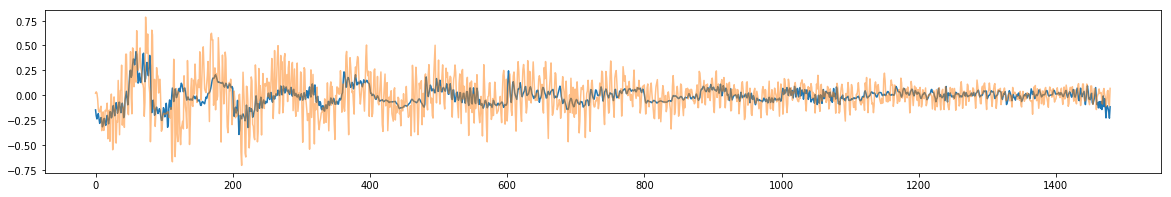

In [13]:
figsize(20,3)
plot(audio, alpha=1.0)
plot(y[:audio.size], alpha=0.5)
plt.savefig("/tmp/reconCompare.pdf")
print(nrmse(audio, y[:audio.size]))

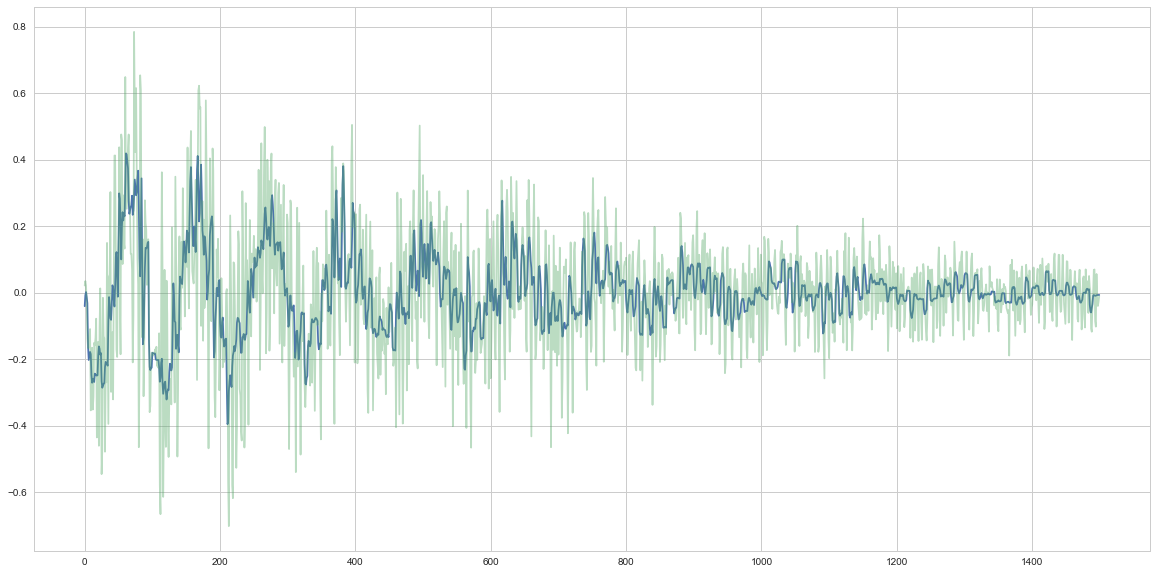

In [100]:
plot(allResults[140]['audio'])
plot(y[:1500], alpha=0.4)

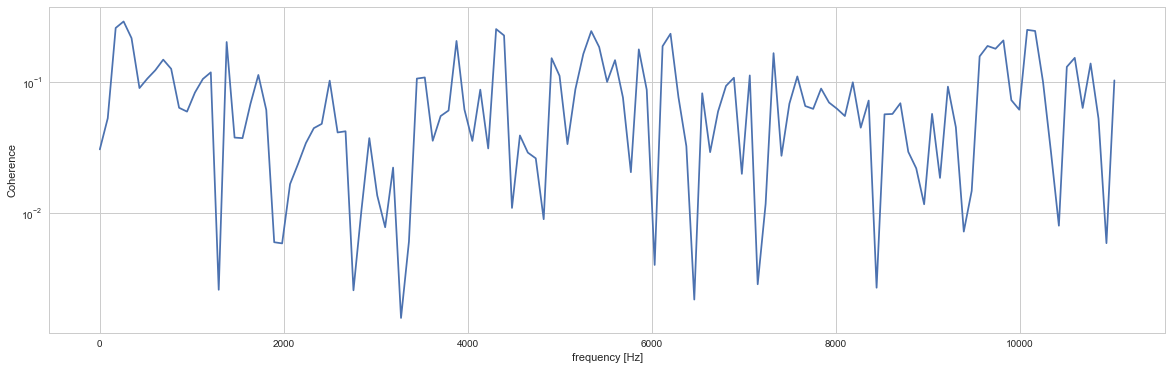

0.918397435083


In [27]:

f, Cxy = signal.coherence(y, allResults[20]['audio'], sr, nperseg=256)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()
print(1 - np.mean(Cxy))

In [67]:
for i, res in enumerate(allResults):
    f, Cxy = signal.coherence(y[:1500], res['audio'], sr, nperseg=128)
    ch = 1 - np.mean(Cxy)
    fp, Pxy = signal.csd(y[:1500], res['audio'], sr, nperseg=128)
    csd = mean(np.abs(Pxy))    
    print(i, res['p']['N'], res['p']['learnLength']/4, ch, csd)

0 200 5.0 0.784740244102 1.24331614008e-06
1 200 5.0 0.772906434249 1.20945768174e-06
2 200 5.0 0.790074295457 1.22406654041e-06
3 200 5.0 0.797942582069 1.22500584419e-06
4 200 5.0 0.777096420358 1.23070236806e-06
5 200 15.0 0.861427412539 9.31604127183e-07
6 200 15.0 0.888301143353 8.31251275728e-07
7 200 15.0 0.891576748702 1.06381469355e-06
8 200 15.0 0.894024922079 9.10418665572e-07
9 200 15.0 0.876235886908 9.13338069776e-07
10 200 25.0 0.870479016066 7.14161935245e-07
11 200 25.0 0.846457949651 7.51816081134e-07
12 200 25.0 0.922529083511 6.43804353796e-07
13 200 25.0 0.873556491862 7.38983299943e-07
14 200 25.0 0.847748717276 8.37231819208e-07
15 200 35.0 0.902999530113 3.8835319918e-07
16 200 35.0 0.901186898587 3.18636328045e-07
17 200 35.0 0.869244362498 5.67872510558e-07
18 200 35.0 0.904116209463 3.84277767705e-07
19 200 35.0 0.878782570967 2.75254312678e-07
20 200 45.0 0.866061123657 5.29523576827e-07
21 200 45.0 0.91530812749 2.91921155063e-07
22 200 45.0 0.879188602616 

In [101]:
allResults[140]

{'audio': array([-0.04065611, -0.00738584,  0.001843  , ..., -0.00704489,
        -0.00681895, -0.00682348]),
 'loading error': 0.0070370613724062368,
 'p': {'BiasScaling': 0.5,
  'LR': 0.99,
  'N': 1000,
  'NetSR': 1.5,
  'NetinpScaling': 1.2,
  'TychonovAlpha': 0.0001,
  'TychonovAlphaReadout': 0.001,
  'learnLength': 20,
  'washoutLength': 20},
 'recon scores': array([ 1.35719728,  1.3892573 ,  1.38464878,  1.39130013,  1.16434637,
         1.3835282 ,  1.1960448 ,  1.38197976,  1.16929928,  1.04772194,
         1.21436194,  1.38498834,  1.39143502,  1.38308559,  0.69401477,
         0.71374203,  0.90045995,  1.17136397,  1.38641157,  1.38329412,
         1.39428217,  1.38528083,  0.52742509,  1.06636267,  0.91967528,
         0.91078507,  1.28686669,  0.81639327,  1.3869389 ,  0.86308448,
         1.11245542,  0.88198462,  1.11549622,  0.79146275,  0.93707048,
         1.29706157,  1.14264546,  0.59236762,  1.32660509,  1.19641197,
         1.32792886,  1.38397347,  0.95946122,  0.

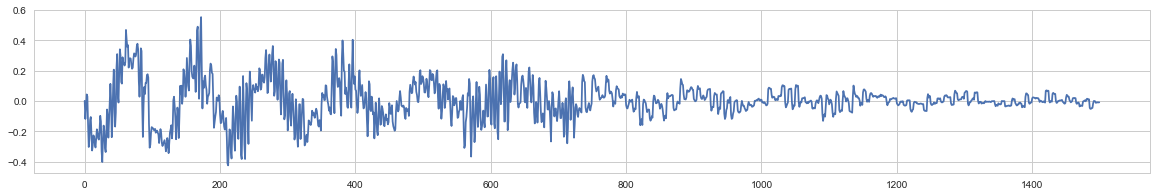

In [94]:
figsize(20,3)
plot(allResults[35]['audio'])
Audio(data=allResults[35]['audio'],rate=sr)

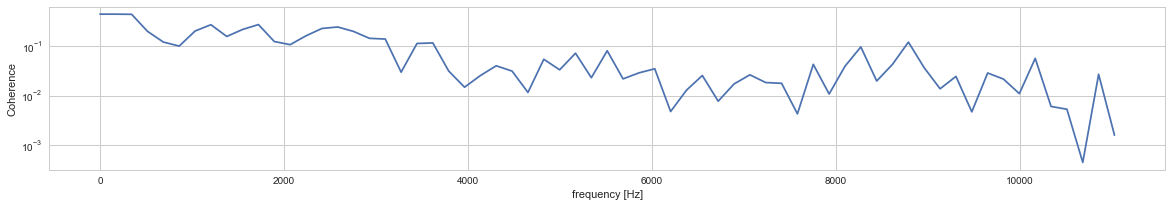

0.912717867581


In [96]:

f, Cxy = signal.coherence(y, allResults[35]['audio'], sr, nperseg=128)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()
print(1 - np.mean(Cxy))

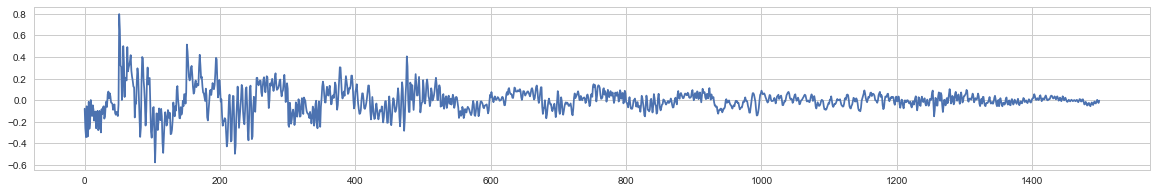

In [45]:
figsize(20,3)
plot(allResults[152]['audio'])
Audio(data=allResults[152]['audio'],rate=sr)

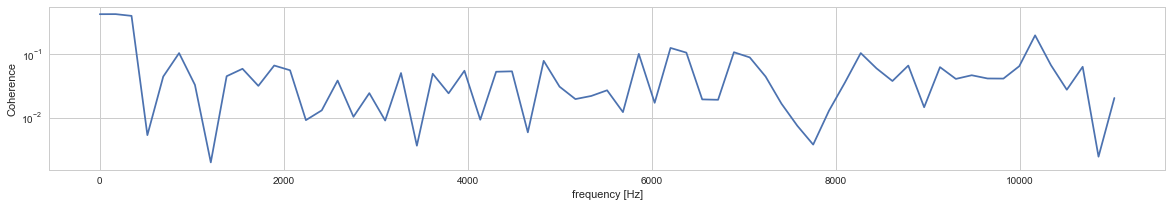

0.939163300102
0.93916329937


In [89]:
f, Cxy = signal.coherence(y/np.max(y), allResults[152]['audio'] / np.max(allResults[152]['audio']), sr, nperseg=128)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()
print(1 - np.mean(Cxy))
def coh(sig1,sig2):
    return 1 - np.mean(signal.coherence(sig1,sig2, sr, nperseg=128)[1])
print(coh(y, allResults[152]['audio']))

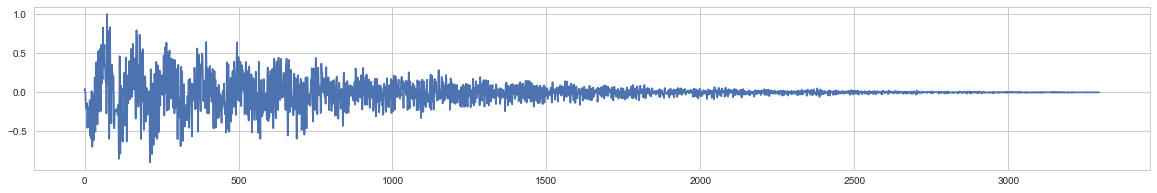

In [57]:
plot(y / np.max(y))

In [58]:
nrmse((y/np.max(y))[:1500], allResults[152]['audio'] / np.max(allResults[152]['audio']))

1.1883717060636907

In [59]:
nrmse(y[:1500], allResults[152]['audio'] )

1.1866291931464368

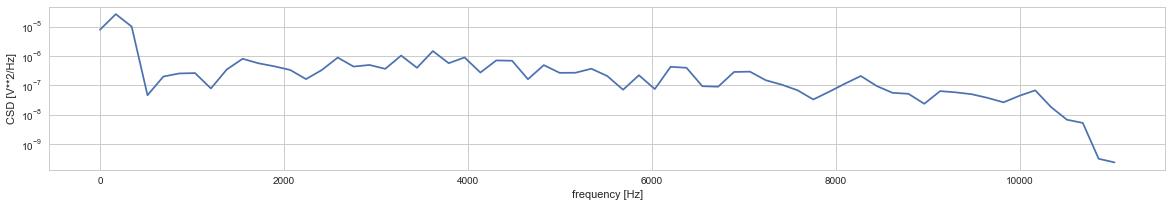

9.44165612045e-07


In [64]:
f, Pxy = signal.csd(y[:1500], allResults[152]['audio'], sr, nperseg=128)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()
print(mean(np.abs(Pxy)))

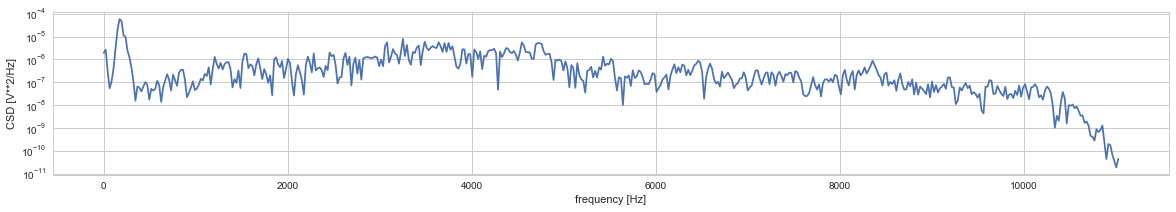

9.43837523827e-07


In [71]:
f, Pxy = signal.csd(y[:1500], allResults[170]['audio'], sr, nperseg=1024)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()
print(mean(np.abs(Pxy)))

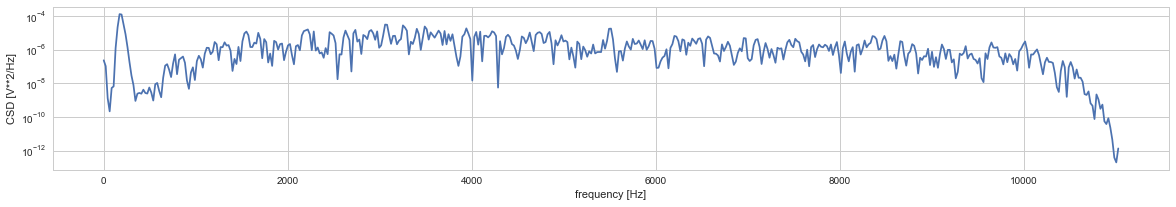

3.27354e-06


In [70]:
f, Pxy = signal.csd(y[:1500], y[:1500], sr, nperseg=1024)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()
print(mean(np.abs(Pxy)))

In [88]:
log10(0.1)

-1.0

In [90]:
def coh(sig1,sig2):
    return 1 - np.mean(signal.coherence(sig1,sig2, sr, nperseg=128)[1])

b = np.array([[x['p']['learnLength']/4, x['p']['N'], coh(y[:1500], x['audio'])] for x in allResults if x['p']['N'] !=0])

In [91]:
b

array([[  5.00000000e+00,   2.00000000e+02,   7.84740244e-01],
       [  5.00000000e+00,   2.00000000e+02,   7.72906434e-01],
       [  5.00000000e+00,   2.00000000e+02,   7.90074295e-01],
       [  5.00000000e+00,   2.00000000e+02,   7.97942582e-01],
       [  5.00000000e+00,   2.00000000e+02,   7.77096420e-01],
       [  1.50000000e+01,   2.00000000e+02,   8.61427413e-01],
       [  1.50000000e+01,   2.00000000e+02,   8.88301143e-01],
       [  1.50000000e+01,   2.00000000e+02,   8.91576749e-01],
       [  1.50000000e+01,   2.00000000e+02,   8.94024922e-01],
       [  1.50000000e+01,   2.00000000e+02,   8.76235887e-01],
       [  2.50000000e+01,   2.00000000e+02,   8.70479016e-01],
       [  2.50000000e+01,   2.00000000e+02,   8.46457950e-01],
       [  2.50000000e+01,   2.00000000e+02,   9.22529084e-01],
       [  2.50000000e+01,   2.00000000e+02,   8.73556492e-01],
       [  2.50000000e+01,   2.00000000e+02,   8.47748717e-01],
       [  3.50000000e+01,   2.00000000e+02,   9.0299953

In [92]:
Ws = [5,15,25,35,45,55,65] 
Ns = [200,400,600,800,1000]
avgs = np.zeros((len(Ws) * len(Ns),3))
idx=0
for v_n in Ns:
    for v_w in Ws:
        g = [v_n, v_w, np.mean([x[2] for x in b if x[0]==v_w and x[1] == v_n])]
        print(g)
        avgs[idx] = g
        idx=idx+1

[200, 5, 0.78455199524725283]
[200, 15, 0.88231322271630597]
[200, 25, 0.87215425167321159]
[200, 35, 0.89126591432562807]
[200, 45, 0.88922934567530443]
[200, 55, 0.89529112303428116]
[200, 65, 0.88194062719738597]
[400, 5, 0.78499815695738917]
[400, 15, 0.87123569881963392]
[400, 25, 0.86837410164601114]
[400, 35, 0.88611159338254475]
[400, 45, 0.88384687182590937]
[400, 55, 0.88115755667613005]
[400, 65, 0.90250696431459265]
[600, 5, 0.78790904413249718]
[600, 15, 0.86850641988107691]
[600, 25, 0.86756772187087816]
[600, 35, 0.8694273120177648]
[600, 45, 0.87791730905596954]
[600, 55, 0.89813041553890538]
[600, 65, 0.90080335167339742]
[800, 5, 0.79435297703722862]
[800, 15, 0.86974543687153061]
[800, 25, 0.8693318883163309]
[800, 35, 0.879480740562402]
[800, 45, 0.86781025404019574]
[800, 55, 0.90917192888627552]
[800, 65, 0.89287726277469126]
[1000, 5, 0.78972186883715789]
[1000, 15, 0.85747731745167355]
[1000, 25, 0.85777085601545333]
[1000, 35, 0.87093227469178025]
[1000, 45, 0.

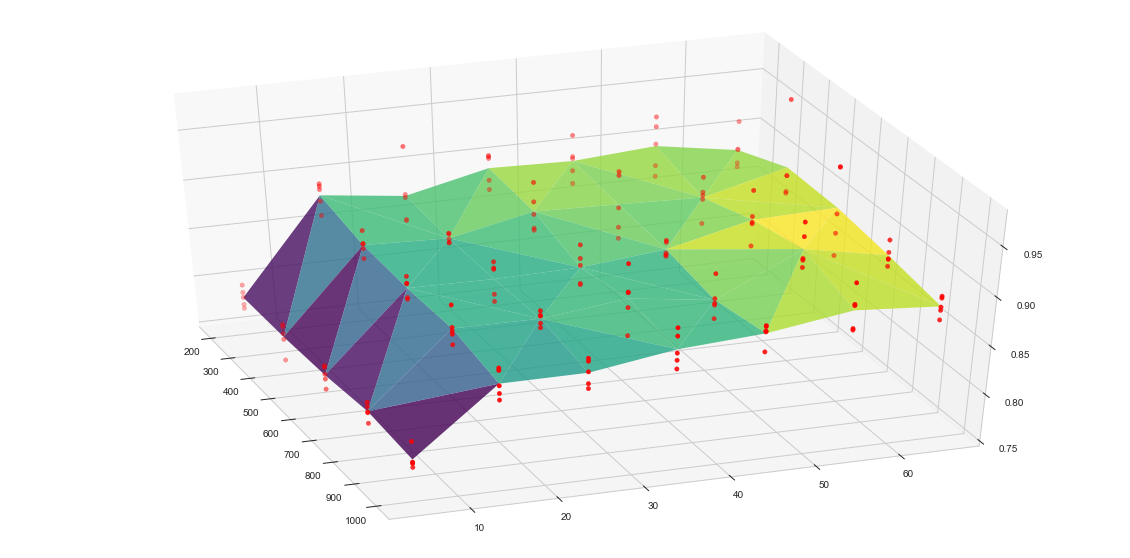

In [97]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=40, azim=-20)
ax.plot_trisurf(avgs[:,0], avgs[:,1], avgs[:,2], cmap=plt.cm.viridis, shade=False, alpha=0.8)
ax.scatter(b[:,1], b[:,0], b[:,2], color='red')
# plt.savefig('surface.png')

# mfccs analysis

In [5]:
def compareMFCCs(seq1, seq2):
    fftSize=2048
    hop=64    
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    mfccs = librosa.feature.mfcc(S=melspec,n_mfcc=20)[1:,:]
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    mfccs2 = librosa.feature.mfcc(S=melspec2,n_mfcc=20)[1:,:]    
    return nrmse(mfccs.flatten(), mfccs2.flatten())

In [6]:
import dill as pickle
with open(r"results/expt1VaryingPatternSize_N.pickled", "rb") as in_file:    
    allResults = pickle.load(in_file)

In [7]:
allResults[0].keys()

dict_keys(['windowSize', 'p', 'recon scores', 'reconScore', 'loading error', 'audio'])

In [8]:
compareMFCCs(y[:allResults[0]['audio'].shape[0]], allResults[0]['audio'])

0.17692700863764757

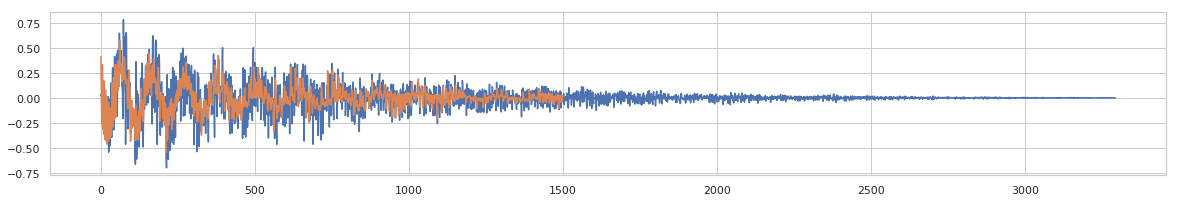

In [9]:
plot(y)
plot(allResults[0]['audio'])

In [10]:
for res in allResults:
    score = compareMFCCs(y[:res['audio'].shape[0]], res['audio'])
    print(score)
    res['mfccScore'] = score

0.17692700863764757
0.17504697896529015
0.1723878697168646
0.1870656522090291
0.1524899982319035
0.3071363063989482
0.348778754021221
0.4498510796266307
0.3949747720505369
0.6304529234402614
0.6221405489217589
0.5491964867516622
0.6747805696681556
0.5414486401643142
0.4434881053532261
1.0969490775615347
1.2317696479149491
0.8912925335552175
1.0991687158841066
1.3092432502990285
0.8261861800581706
1.2856437282415896
0.7333758650314341
1.430774378041819
1.2815233059936675
1.1412803376352245
1.111960639983168
1.074320538586401
1.3543426468132882
1.3731512459465842
1.221841283416396
1.3389231278363387
1.1440498837188375
1.2937523460719804
1.4184936597422961
0.20514942059620714
0.2593181088252456
0.18532018208567672
0.23345829001468021
0.19458911832437015
0.24751392326148364
0.19670138783926644
0.24445715766621587
0.23149588343734256
0.28233162077660057
0.23332422297464897
0.6153169883345015
0.4421556765637589
0.3552167883220529
0.35475039398840813
1.0762702982906658
0.7682599213413168
0.79

In [11]:
c = np.array([[x['p']['learnLength']/4, x['p']['N'], x['mfccScore']] for x in allResults if x['p']['N'] !=0])

In [12]:
c

array([[5.00000000e+00, 2.00000000e+02, 1.76927009e-01],
       [5.00000000e+00, 2.00000000e+02, 1.75046979e-01],
       [5.00000000e+00, 2.00000000e+02, 1.72387870e-01],
       [5.00000000e+00, 2.00000000e+02, 1.87065652e-01],
       [5.00000000e+00, 2.00000000e+02, 1.52489998e-01],
       [1.50000000e+01, 2.00000000e+02, 3.07136306e-01],
       [1.50000000e+01, 2.00000000e+02, 3.48778754e-01],
       [1.50000000e+01, 2.00000000e+02, 4.49851080e-01],
       [1.50000000e+01, 2.00000000e+02, 3.94974772e-01],
       [1.50000000e+01, 2.00000000e+02, 6.30452923e-01],
       [2.50000000e+01, 2.00000000e+02, 6.22140549e-01],
       [2.50000000e+01, 2.00000000e+02, 5.49196487e-01],
       [2.50000000e+01, 2.00000000e+02, 6.74780570e-01],
       [2.50000000e+01, 2.00000000e+02, 5.41448640e-01],
       [2.50000000e+01, 2.00000000e+02, 4.43488105e-01],
       [3.50000000e+01, 2.00000000e+02, 1.09694908e+00],
       [3.50000000e+01, 2.00000000e+02, 1.23176965e+00],
       [3.50000000e+01, 2.00000

In [13]:
Ws = [5,15,25,35,45,55,65] 
Ns = [200,400,600,800,1000]
avgs = np.zeros((len(Ws) * len(Ns),3))
idx=0
for v_n in Ns:
    for v_w in Ws:
        g = [v_n, v_w, np.mean([x[2] for x in c if x[0]==v_w and x[1] == v_n])]
        print(g)
        avgs[idx] = g
        idx=idx+1

[200, 5, 0.17278350155214697]
[200, 15, 0.42623876710751957]
[200, 25, 0.5662108701718234]
[200, 35, 1.1256846450429674]
[200, 45, 1.1115006914733363]
[200, 55, 1.2110110817929332]
[200, 65, 1.2834120601571697]
[400, 5, 0.21556702396923594]
[400, 15, 0.24049999459618182]
[400, 25, 0.4001528140366741]
[400, 35, 0.913500742217183]
[400, 45, 0.5776802954207951]
[400, 55, 0.96572626335645]
[400, 65, 1.3360934266488482]
[600, 5, 0.22022676307465744]
[600, 15, 0.24098707680343212]
[600, 25, 0.37479435612760686]
[600, 35, 0.8085809069199167]
[600, 45, 0.6894634922565258]
[600, 55, 1.1453403015571428]
[600, 65, 0.9960164212090394]
[800, 5, 0.23948824184835305]
[800, 15, 0.18954225512829947]
[800, 25, 0.3938520328422802]
[800, 35, 0.9211080716574654]
[800, 45, 0.4937782509209071]
[800, 55, 1.1443743907432318]
[800, 65, 0.9710098388184086]
[1000, 5, 0.25796630338184023]
[1000, 15, 0.20801972781256312]
[1000, 25, 0.3367885332493147]
[1000, 35, 0.7353012995442164]
[1000, 45, 0.48817017315452305]
[

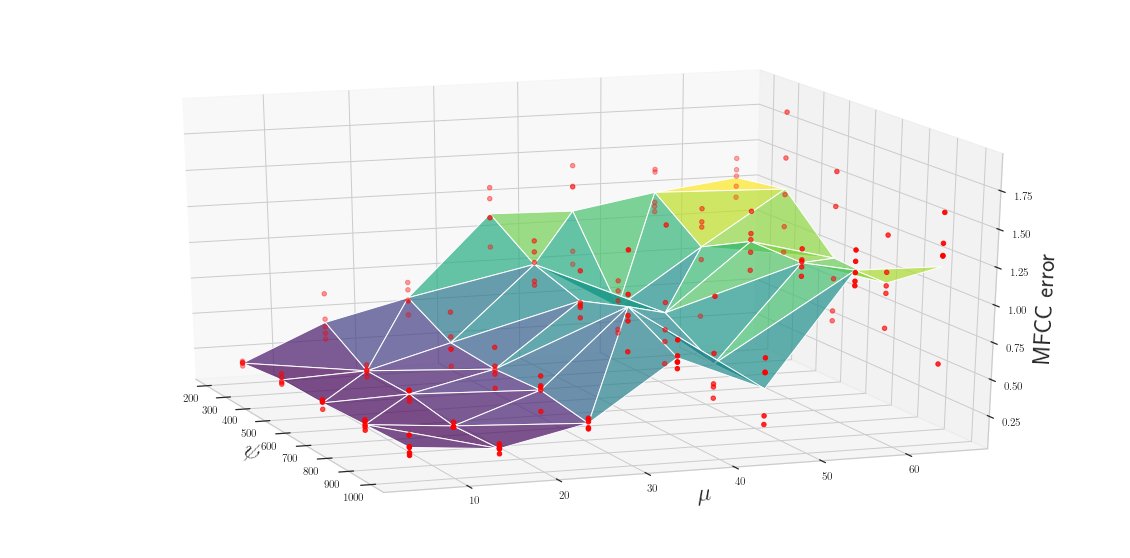

In [22]:
from mpl_toolkits.mplot3d import Axes3D
figsize(20,10)
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=20, azim=-20)
ax.set_xlabel('$\psi$', fontsize=24)
ax.set_ylabel('$\mu$', fontsize=24)
ax.set_zlabel('MFCC error', fontsize=24)
ax.plot_trisurf(avgs[:,0], avgs[:,1], avgs[:,2], cmap=plt.cm.viridis, shade=True, alpha=0.7)
ax.scatter(c[:,1], c[:,0], c[:,2], color='red')
plt.savefig('tmp/surface.pdf', bbox_inches='tight')